In [52]:
import pandas as pd 
import numpy as np 
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Deep Neural Networks Laboratory

## Dataset

A Neural Network should always be built considering the dataset at hand.

In our case, we will continue our example with the Wine Dataset we built in the previous notebook.

In [54]:
class GenericDataset(Dataset):
    def __init__(self, targets_file, data_file, transform=None, target_transform=None):
        self.targets_file = pd.read_csv(targets_file)

        scaler = StandardScaler()        
        self.data_file = pd.read_csv(data_file)
        self.data_file = scaler.fit_transform(self.data_file)
        self.data_file = pd.DataFrame(self.data_file)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets_file)

    def __getitem__(self, idx):

        
        return self.data_file.iloc[idx].to_numpy(dtype=np.float32), self.targets_file.iloc[idx].item()
    
    def get_dataset(self):
        return self.data_file, self.targets_file

In [55]:
folder = os.path.join('data', 'iris')

In [56]:
WineDataset = GenericDataset(targets_file=os.path.join(folder, 'targets.csv'), data_file=os.path.join(folder, 'data.csv'))

In [57]:
train_size = int(0.9 * len(WineDataset))
test_size = len(WineDataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(WineDataset, [train_size, test_size])

In [58]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [59]:
next(iter(train_dataloader))

[tensor([[ 0.5533,  0.5693,  1.2745,  1.7109],
         [ 0.3110, -0.3564,  0.5353,  0.2647],
         [-0.1737,  3.1147, -1.2844, -1.0500],
         [ 0.1898,  0.8007,  0.4216,  0.5276],
         [-1.5065,  0.3378, -1.3413, -1.3130],
         [ 0.3110, -1.0506,  1.0471,  0.2647],
         [ 0.1898, -0.8192,  0.7628,  0.5276],
         [ 1.0380, -1.2820,  1.1608,  0.7906],
         [-0.9007,  1.7263, -1.0569, -1.0500],
         [ 2.2497, -0.5878,  1.6726,  1.0535],
         [ 0.7957, -0.1250,  0.9902,  0.7906],
         [-0.7795, -0.8192,  0.0804,  0.2647],
         [-0.4160, -1.7448,  0.1372,  0.1332],
         [-0.5372,  1.4949, -1.2844, -1.3130],
         [-1.7489, -0.1250, -1.3981, -1.3130],
         [-1.7489, -0.3564, -1.3413, -1.3130]]),
 tensor([2, 1, 0, 1, 0, 2, 1, 2, 0, 2, 2, 1, 1, 0, 0, 0])]

In [60]:
WineDataset.get_dataset()[0]

,0,1,2,3
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977
...,...,...,...,...
145,1.038005,-0.124958,0.819624,1.447956
146,0.553333,-1.281972,0.705893,0.922064
147,0.795669,-0.124958,0.819624,1.053537
148,0.432165,0.800654,0.933356,1.447956


## Neural Network

Pytorch is useful to build fully customizable Neural Networks.
Keep in mind these three things:

1. Our Neural Network will extend the class ```nn.Module```. 

2. The layers will be initialized inside ```__init__```.

3. The operations on the input data are defined in the ```forward``` method.

In [61]:
class FirstNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 40)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(40, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 20)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(20, 3)  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

In [62]:
model = FirstNeuralNetwork()
model.to(device)

FirstNeuralNetwork(
  (fc1): Linear(in_features=4, out_features=40, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=40, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=20, bias=True)
  (relu3): ReLU()
  (output_layer): Linear(in_features=20, out_features=3, bias=True)
)

In [63]:
def train_loop(dataloader, model, loss_fn, optimizer):
  
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)

    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)

      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  return 100*correct

In [64]:
learning_rate = 1e-4
batch_size = 16
epochs = 20

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    accuracies.append(test_loop(test_dataloader, model, loss_fn))
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 53.3%, Avg loss: 1.024429 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.017277 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 66.7%, Avg loss: 1.009917 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.002798 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.994162 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.985370 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.976615 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.966698 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.955856 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.944500 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 86.7%, Avg los

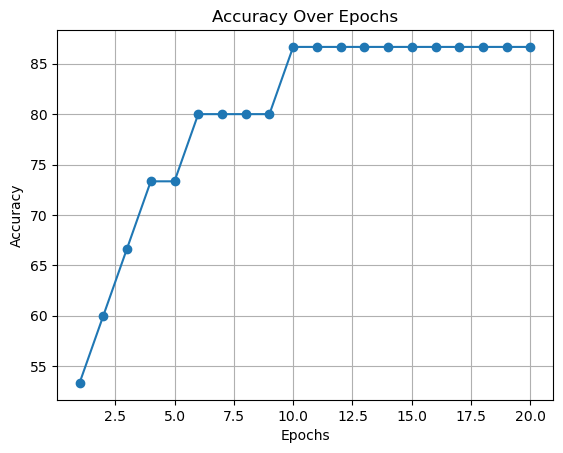

In [66]:
import matplotlib.pyplot as plt

epochs = range(1, len(accuracies) + 1)

plt.plot(epochs, accuracies, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

## Example predictions

In [67]:
i = 0

for X,y in test_dataloader:
  print('label', y)

  X, y = X.to(device), y.to(device)

  pred = model(X)
  pred = pred.argmax(1)
  print('prediction:', pred)
  print("____________________")

  if i > 3:
    break

  i += 1

label tensor([0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0])
prediction: tensor([0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0], device='cuda:0')
____________________


## Is the dataset unabalanced?

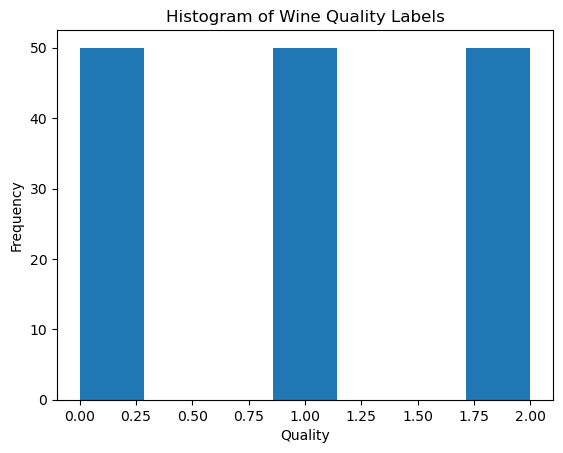

In [68]:
labels = WineDataset.get_dataset()[1].to_numpy()

#plot histogram
plt.hist(labels, bins=7)
plt.title('Histogram of Wine Quality Labels')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()